In [27]:
## import all necessary packages
import time
import json

import numpy as np
import matplotlib.pyplot as plt

from pandas import *

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

# Part 1. Clustering: the baseline (20 points).
**1. Write a script that applies the k-means clustering method to the 100K subset. Measure a
typical processing time. Experimentally detect the maximum number of clusters k that
can be handled with the implementation of the algorithm you are using.**

In [28]:
with open('tweets_1M.json','r') as f:
    tweets = json.load(f)

In [29]:
len(tweets)

1000000

In [30]:
subset_tweets = tweets[:100000]
len(subset_tweets)

100000

In [31]:
#subset_tweets[:5]
tweet_df = DataFrame(subset_tweets)
tweet_df.head()

,id,lat,lng,text,timeStamp,user_id
0,377652254096228352,37.446100,-121.883557,@Tanner_Cortez hey checkout the website: http:...,Wed Sep 11 04:38:08 +0000 2013,224874450
1,377652255346159616,34.087406,-117.462604,@Lennayy7 😪,Wed Sep 11 04:38:08 +0000 2013,312179473
2,377652262325456897,37.356131,-121.842867,i laugh a lot with that line,Wed Sep 11 04:38:10 +0000 2013,54351774
3,377652264682655744,37.364664,-122.009629,sons of anarchy is back on woop woop,Wed Sep 11 04:38:11 +0000 2013,343219606
4,377652271116722176,37.382600,-121.995000,Drinking a Fresh Squeezed IPA by @deschutesbee...,Wed Sep 11 04:38:12 +0000 2013,1569395935


In [68]:
# convert json into list of lat and long
coordinate_tweets = [value for item in subset_tweets for key,value in item.items() if key in ['lat','lng']]

pair_coordinates = []
for i,k in zip(coordinate_tweets[0::2], coordinate_tweets[1::2]):
    pair_coordinates.append([k,i])

# convert pair to meters
pair_coordinates = [[item[0]*89.7, item[1]*112.7] for item in pair_coordinates]

print(len(pair_coordinates))
print(pair_coordinates[:5])


100000
[[3358.915169103, -13736.276859249001], [3057.640302951, -13238.035471927002], [3350.84495967, -13731.691155980001], [3351.610399371, -13750.485163506], [3353.21922, -13748.836500000001]]


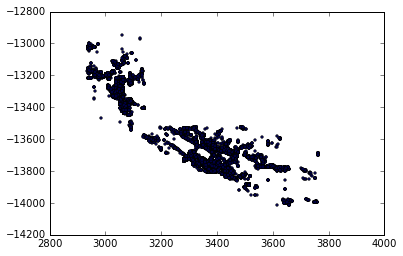

In [69]:
# create scater plot
lat = [x[0] for x in pair_coordinates]
long = [x[1] for x in pair_coordinates]
plt.scatter(lat, long, marker=u'.')

In [70]:
# testing how KMeans works
k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(pair_coordinates)
t_batch = time.time() - t0
k_means_labels = k_means.labels_                       
k_means_cluster_centers = k_means.cluster_centers_     
k_means_labels_unique = np.unique(k_means_labels)      
print(t_batch)

0.530174970626831


In [71]:
print("the cluster centers through k_means are: {0}".format(k_means_cluster_centers))
print("the unique cluster labels are: {0}".format(k_means_labels_unique))

the cluster centers through k_means are: [[  3437.67777789 -13667.74174164]
 [  3046.77374518 -13264.46290665]
 [  3370.78817178 -13767.02349929]]
the unique cluster labels are: [0 1 2]


In [72]:
# create function for k_means in order to loop over cluster_size
def k_means_time(cluster_size):
    k_means = KMeans(init='k-means++', n_clusters=cluster_size, n_init=10)
    t0 = time.time()
    k_means.fit(pair_coordinates)
    t_batch = time.time() - t0
    return t_batch

k_means_interval = []
for x in range(1,50):
    k_means_interval.append((x,round(k_means_time(x),2)))
    

In [73]:
interval_df = DataFrame(k_means_interval)
interval_df

,0,1
0,1,0.13
1,2,0.17
2,3,0.49
3,4,0.66
4,5,0.74
5,6,1.00
6,7,1.02
7,8,1.40
8,9,1.79
9,10,1.73


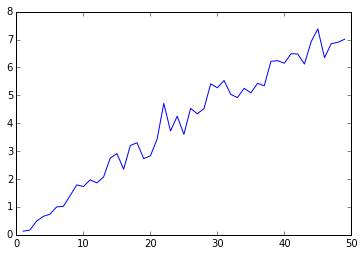

In [74]:
plt.plot(interval_df[0],interval_df[1])

### Cluster Size of 100

In [75]:
k_means_time(100)

14.681398868560791

### Cluster Size of 500

In [76]:
k_means_time(500)

76.9750509262085

### Cluster Size of 1000

In [77]:
k_means_time(1000)

135.70429491996765

## Conclusion part 1 k-means:
from 20 clusters to 100 clusters (ie x5) takes a difference of ~10 seconds, while 100 clusters to 500 clusters (ie again x5) takes a difference of ~60 seconds, meaning each cluster takes exponentially more time. However, there doesn't seem to a bottleneck

**2. Write a script that applies the MiniBatch k-means method to the 100K subset. Select an
appropriate value of a batch size. Measure and note the gain in computational time.
Evaluate the maximum number of clusters k that can be handled with the implementation
of the algorithm you are using.**

In [78]:
# create mini batch function that takes clustersize and batchsize as parameters
def mbk_time(cluster_size, batch_size):
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=cluster_size, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
    t0 = time.time()
    mbk.fit(pair_coordinates)
    t_mini_batch = time.time() - t0
    return t_mini_batch

In [79]:
# Find optimal batch size first
# keep cluster size content the same (n=3) and see where batch size is optimal
mbk_means_batch = []
x = 10
while x < 2000:
    mbk_means_batch.append((x,round(mbk_time(cluster_size=3, batch_size=x),2)))
    x += 10

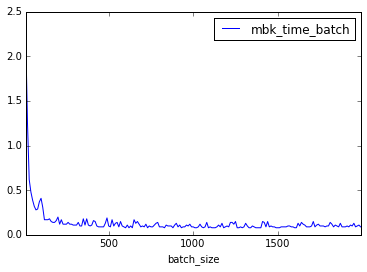

In [80]:
# plot optimal max size
mbk_batch_df = DataFrame(mbk_means_batch)
mbk_batch_df.columns = ['batch_size', 'mbk_time_batch']
mbk_batch_df.plot(x = 'batch_size',y = 'mbk_time_batch')

In [81]:
# minimum batch around 1000
min_batch = mbk_batch_df['batch_size'][mbk_batch_df['mbk_time_batch']==mbk_batch_df['mbk_time_batch'].min()].values
print(min_batch)

[ 600  620  640  730  830  880  930 1010 1020 1060 1090 1110 1120 1130 1180
 1260 1270 1290 1330 1340 1370 1380 1390 1400 1490 1500 1510 1600 1610]


In [82]:
# Find optimal cluster size using 1000 as the batchsize
# keep cluster size content the same (n=3) and see where batch size is optimal
mbk_means_cluster = []
x = 10
while x < 500:
    mbk_means_cluster.append((x,round(mbk_time(cluster_size=x, batch_size=1200),2)))
    x += 10

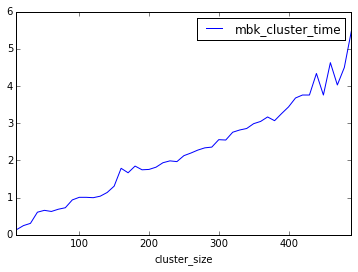

In [83]:
# plot optimal max size
mbk_cluster_df = DataFrame(mbk_means_cluster)
mbk_cluster_df.columns = ['cluster_size', 'mbk_cluster_time']
mbk_cluster_df.plot(x = 'cluster_size',y = 'mbk_cluster_time')

In [84]:
mbk_time(100, 1200)

0.9384920597076416

## Conclusion Part 1 mini-batch k-means:
For mbk the optimal batch size is around 1000 (given 3 clusters). The cluster size has a positive relationship with time; my computer breaks on limit above 500

**3. Write a script that applies the DBScan method to the 100K subset. Fix the min number of
samples in a cluster as 100. Experimentally explore the influence of the connectivity
threshold ε on the number of clusters detected by DBScan.**

In [85]:
def dbscan_time(eps_n, min_samples_n):
    t0 = time.time()
    mdb = DBSCAN(eps=eps_n, min_samples=eps_n).fit(pair_coordinates)
    n_labels = mdb.labels_ 
    n_clusters = len(set(n_labels)) - (1 if -1 in n_labels else 0)
    t_dbscan = time.time() - t0
    return t_dbscan, n_clusters

In [50]:
# dbscan on epsilon of 0.00001 to 0.1 (NOTE THIS IS APPROPRIATE FOR LAT LONG)
# dbscan_interval = []
# for x in range(5):
#     dbscan_interval.append(((10**(-5))*(10**x), 
#         dbscan_time(eps_n=(10**(-5))*(10**x), min_samples_n=100)))
    

In [100]:
dbscan_interval = []
for x in range(1,8):
    dbscan_interval.append(
        (x, 
        dbscan_time(eps_n=x, min_samples_n=100))
    )

In [95]:
# dbcan of eps 0.1 will give about 100 clusters
dbscan_time(eps_n=6.5, min_samples_n=100)



(15.274581909179688, 99)

[(1, (2.648797035217285, 2620)), (2, (4.158386945724487, 941)), (3, (5.8765740394592285, 480)), (4, (7.185170888900757, 305)), (5, (9.868433952331543, 183)), (6, (13.288019895553589, 127)), (7, (17.5035400390625, 89))]


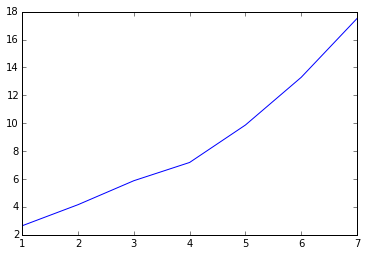

In [102]:
# GRAPH BELOW: x = epsilon; y = time

print(dbscan_interval)

dbscan_eps_x = [x[0] for x in dbscan_interval]
dbscan_time_y = [x[1][0] for x in dbscan_interval]

plt.plot(dbscan_eps_x,dbscan_time_y)

[(1, (2.648797035217285, 2620)), (2, (4.158386945724487, 941)), (3, (5.8765740394592285, 480)), (4, (7.185170888900757, 305)), (5, (9.868433952331543, 183)), (6, (13.288019895553589, 127)), (7, (17.5035400390625, 89))]


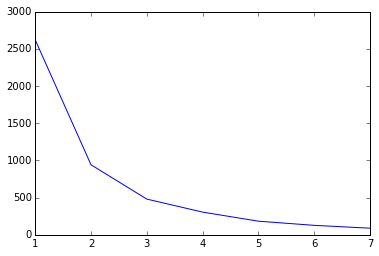

In [103]:
# GRAPH BELOW: x = epsilon; y = number of clusters created

print(dbscan_interval)

dbscan_eps_x = [x[0] for x in dbscan_interval]
dbscan_time_y = [x[1][1] for x in dbscan_interval]

plt.plot(dbscan_eps_x,dbscan_time_y)

### Conclusion Part 1 DBSCAN
The lower the epsilon the faster the dbscan time--exponential growth in time

# Part 2. Clustering: scalability (40 points).
**2.1. For k-means and MiniBatch k-means algorithms, run the experiments and plot the graphs
representing the computational time as a function of:
a) Number of data samples (consider the range of 100 to 100’000) for a fixed k =100.**

** k-means a) Number of data samples (consider the range of 100 to 100’000) for a fixed k =100. **

In [104]:
def k_means_time_2(index_pair):
    k_means = KMeans(init='k-means++', n_clusters=100, n_init=10)
    t0 = time.time()
    k_means.fit(pair_coordinates[:index_pair])
    t_batch = time.time() - t0
    return t_batch

In [105]:
k_means_interval_2 = []
x = 100
while x <= 100000:
    k_means_interval_2.append((x,round(k_means_time_2(x),2)))
    x += 5000

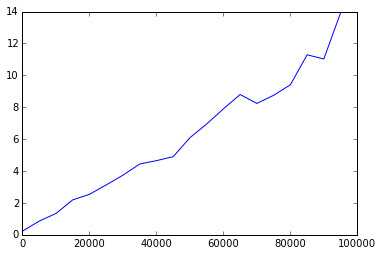

In [106]:
interval_df_2 = DataFrame(k_means_interval_2)
plt.plot(interval_df_2[0],interval_df_2[1])

** mini-batch a) Number of data samples (consider the range of 100 to 100’000) for a fixed k =100.**

In [107]:
def mbk_time_2(cluster_size, batch_size, n_points):
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=cluster_size, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
    t0 = time.time()
    mbk.fit(pair_coordinates[100:n_points])
    t_mini_batch = time.time() - t0
    return t_mini_batch

In [108]:
mbk_cluster_2 = []
x = 500
while x <= 100000:
    mbk_cluster_2.append((x,round(mbk_time_2(cluster_size=100, batch_size=900, n_points=x),2)))
    x += 5000

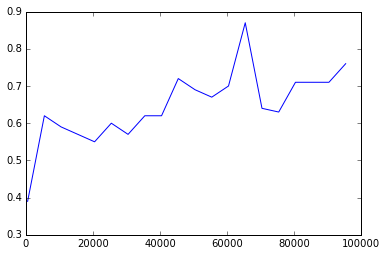

In [109]:
mbk_df_2 = DataFrame(mbk_cluster_2)
plt.plot(mbk_df_2[0],mbk_df_2[1])

** k_means b) Number of requested clusters k (consider the range of 2 to the k_max)**

In [110]:
k_means_interval_2b = []
x = 2
while x <= 100:
    k_means_interval_2b.append((x,round(k_means_time(x),2)))
    x += 10

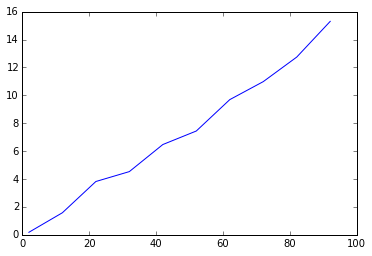

In [111]:
k_means_2b = DataFrame(k_means_interval_2b)
plt.plot(k_means_2b[0],k_means_2b[1])

** mbk_means b) Number of requested clusters k (consider the range of 2 to the k_max)**

In [112]:
mbk_cluster_2b = []
x = 2
while x <= 1000:
    mbk_cluster_2b.append((x,round(mbk_time_2(cluster_size=x, batch_size=1200,
                                              n_points=100000),2)))
    x += 50

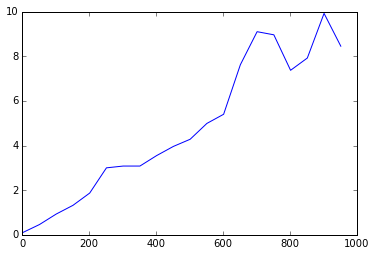

In [113]:
mbk_2b_df = DataFrame(mbk_cluster_2b)
plt.plot(mbk_2b_df[0],mbk_2b_df[1])

**dbscan 2.2 a) For DBScan algorithm, plot the graphs representing computational time as a function of: a) Number of samples (consider the range of 100 to 100’000) for a fixed ε_100, MinPts = 100.**

In [114]:
def dbscan_time_nsize(n_size, eps_n, min_samples_n):
    t0 = time.time()
    mdb = DBSCAN(eps=eps_n, min_samples=min_samples_n).fit(pair_coordinates[:n_size])
    t_dbscan = time.time() - t0
    return t_dbscan

In [115]:
x = 100
dbscan_nsize = []
while x <= 21100:
    dbscan_nsize.append(
        (
            x,
            dbscan_time_nsize(n_size = x, eps_n=100, min_samples_n=100)
        )
    )
    x += 1000

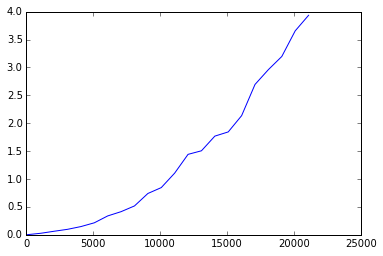

In [116]:
dbscan_nsize_df = DataFrame(dbscan_nsize)
plt.plot(dbscan_nsize_df[0],dbscan_nsize_df[1])